# Feature Sets Experiments

In this notebook we analyse results obtained from the feature sets experiments. The experimental design is as follows:

2. Let $m$ represent the machine learning model where $m$ $\in$ `["ADA", "LR", "DT", "RF"]`
3. Let $full$, $train$ and $test$ represent the full, training & testing subsets respectively. $train$ and $test$ are $0.75$ and $0.25$ of $full$ respectively
4. Let $train_{n}$ and $test_{n}$ be sub-subsets of the corresponding subsets where `n` $\in$ `[3, max(num_features)]`
5. Let $m\prime_{n}$ be the model trained using $train_{n}$
6. Let $\hat{y}_{n, m\prime}$ be the predictions obtained from $m\prime_{n}$ on $test_{n}$
7. Let $d$ represent the group fairness metric where $d$ $\in$ `["DI", "SPD"]`
7. Let $v_{test, n, d}$ be data fairness metrics calculated using $test_{n}$. Similarly, let $v_{train, n, d}$ be data fairness metrics calculated using $train_{n}$
1. Let $v_{n, m\prime, d}$ be the model fairness metrics calculated using $\hat{y}_{n, m\prime}$
1. We can reduce the granularity a bit for the analysis by considering the fairness metrics across the sub-subsets. Let $v_{test, d}$, $v_{train, d}$ and $v_{m\prime, d}$ represent the fairness metrics across the sub-subsets.

The objective is to analyse the following:
1. Relationship between $v_{test, d}$ and $v_{m\prime, d}$
2. Relationship between $v_{train, d}$ and $v_{m\prime, d}$
3. And finally relationship between $v_{test, d}$, $v_{train, d}$ and $v_{m\prime, d}$

Our hypothesis is that $v_{test/train, d}$ and $v_{m\prime, d}$ have some form of relationship. Another way of formulating the above statement is that the two random variables have similar distribution.

We employ two types of tests to verify our hypothesis:
1. Correlation and
2. Linear regression

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [22]:
import glob
from src.data import process

batch1 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-feature-sets-*-25.csv"))]
batch2 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-feature-sets-*-25-2.csv"))]

batch1 = pd.concat(batch1)
batch2 = pd.concat(batch2)

# we need to reset the `iteration` column for the second batch
# since we use this column as the index when calculating the
# correlation (see correlation cell below) & we cannot have
# duplicates in this column
batch2["iteration"] = batch2["iteration"] + 25
data = pd.concat([batch1, batch2])
data.shape

(112500, 26)

In [23]:
# preprocessing the data prior to analysis
# 1. fairness metrics are only calculated when privileged == None
# 2. scale fairness metrics according to zhang2021ignorance paper
# 3. combine dataset_label & protected
# 4. set the index to iteration
# 4. drop unused columns
# 4. rename column names
# 4. rename model names
data = data[data["privileged"] == "None"]
process(data)
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data = data.rename(columns={
    "dataset_label": "dataset",
    "subset_label": "subset",
    "disparate_impact": "DI",
    "statistical_parity_difference": "SPD",
})
data = data.set_index("iteration")
data = pd.concat([
    data.loc[(data["subset"] == "train")], # DFM
    data.loc[(data["subset"] == "test") & (data["model"] != "None")], # MFM
])
data = data[[
    "DI",
    "SPD",
    "num_features",
    "model",
    "dataset",
    "f1",
    "accuracy",
]]
data.loc[(data["model"] == "logisticregression"), "model"] = "LR"
data.loc[(data["model"] == "randomforestclassifier"), "model"] = "RF"
data.loc[(data["model"] == "adaboostclassifier"), "model"] = "ADA"
data.loc[(data["model"] == "decisiontreeclassifier"), "model"] = "DT"

data.shape

(31250, 7)

## Data validation

In this section I am performing some data quality checks to ensure that the data collection scripts worked as expected.

In [24]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points
datasets = ["german-age", "german-sex", "compas-race", "compas-sex", "meps-race", "bank-age", "adult-race", "adult-sex"]
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = _.loc[
        (_["dataset"] == dataset) &
        (_["model"] == "None")
    ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*50

    _ = _.loc[
        (_["dataset"] == dataset) &
        (_["model"] == "None")
    ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*50


    for model in models:
        _ = data.loc[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*50

# Shapiro-wilk test for normality
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

In [68]:
pvalues = {
    "dataset": [],
    "subset": [],
    "model": [],
    "DI": [],
    "SPD": [],
}

for dataset in datasets:
    _ = data.loc[("test")]
    _ = _[
        (_["dataset"] == dataset) &
        (_["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["subset"].append("test")
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    _ = data.loc[("train")]
    _ = _[
        (_["dataset"] == dataset) &
        (_["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["subset"].append("train")
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
        pvalues["dataset"].append(dataset)
        pvalues["subset"].append("test")
        pvalues["model"].append(model)
        pvalues["DI"].append(shapiro(_["DI"]).pvalue)
        pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

pvalues = pd.DataFrame(data=pvalues)
pvalues["DI"] = pvalues["DI"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues["SPD"] = pvalues["SPD"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues


,dataset,subset,model,DI,SPD
0,compas-sex,test,None,,
1,compas-sex,train,None,,
2,compas-sex,test,LR,**,***
3,compas-sex,test,DT,,***
4,compas-sex,test,ADA,***,***
5,compas-sex,test,RF,,**
6,german-age,test,None,**,***
7,german-age,train,None,,
8,german-age,test,LR,**,***
9,german-age,test,DT,***,***


# Distributional Analysis
In this section we analyse the distribution of the fairness metrics. We employ the following methods:

1. Distribution of the data fairness metrics (and model fairness metrics) when $num\_features = max(num\_features)$
2. Distribution of the data fairness metrics (and model fairness metrics) within each $num\_features$
3. Distribtion of the data fairness metrics (and model fairness metrics) across each $num\_features$

We limit our analysis first to the adult-sex dataset.

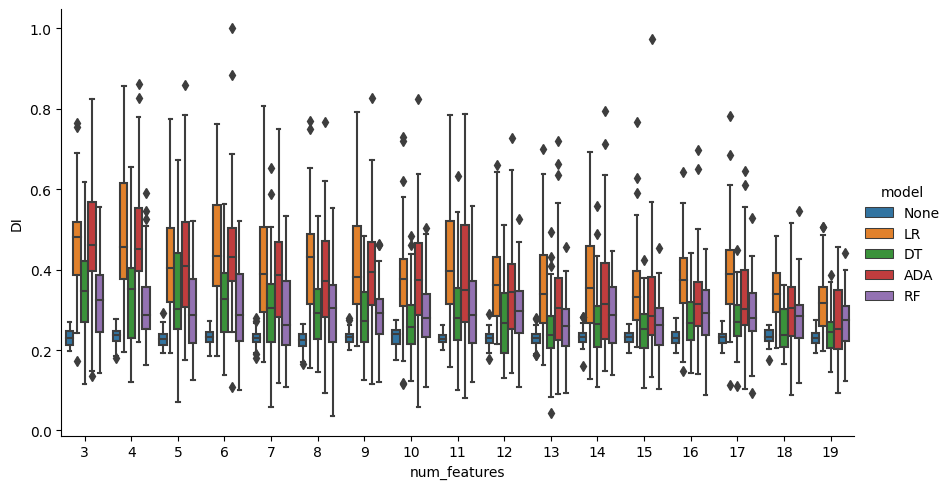

In [25]:
sns.catplot(
    data=data[data["dataset"] == "bank-age"],
    kind="box",
    x="num_features",
    y="DI",
    hue="model",
    aspect=1.75,
)

# Relational analysis

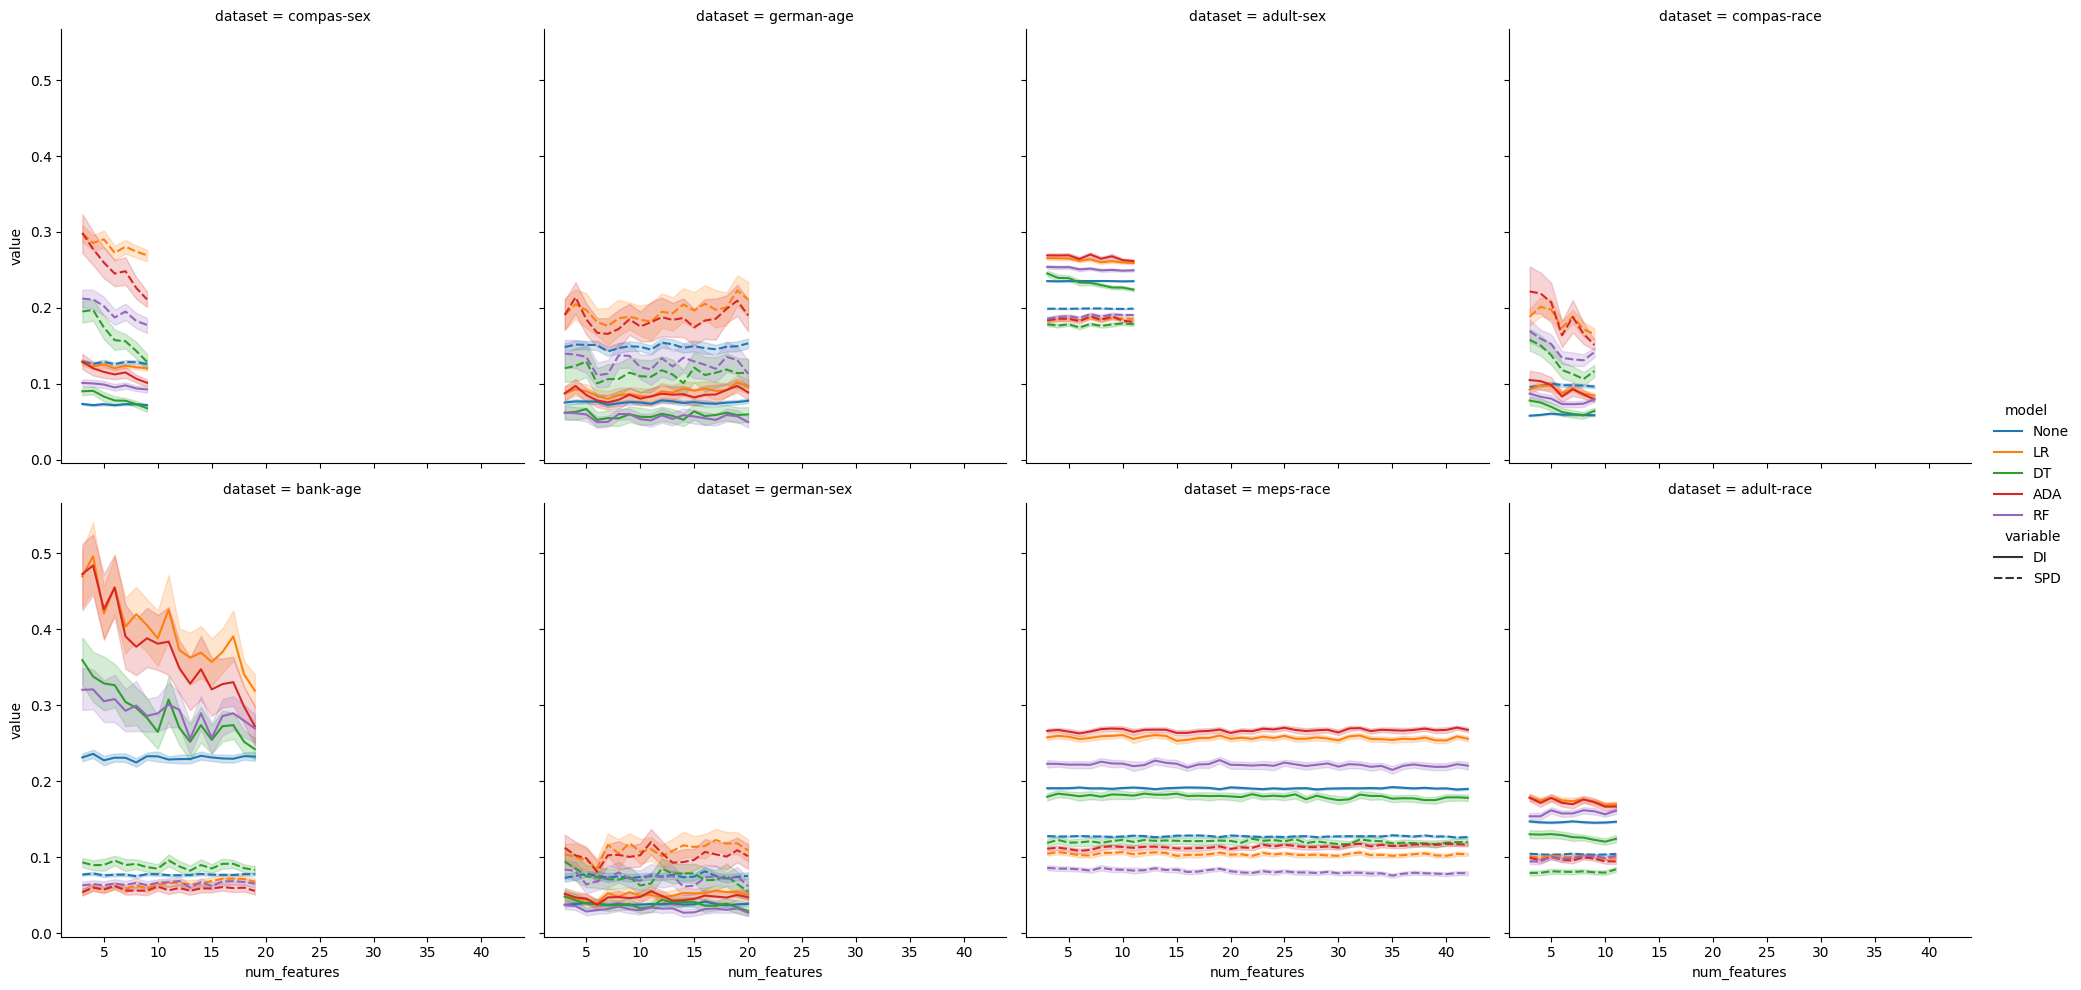

In [41]:
id_vars = ["num_features", "model", "dataset", "accuracy", "f1"]

sns.relplot(
    kind='line',
    data=data.melt(id_vars=id_vars),
    x="num_features",
    y="value",
    hue="model",
    style="variable",
    col="dataset",
    col_wrap=4,
)

<AxesSubplot: xlabel='num_features', ylabel='value'>

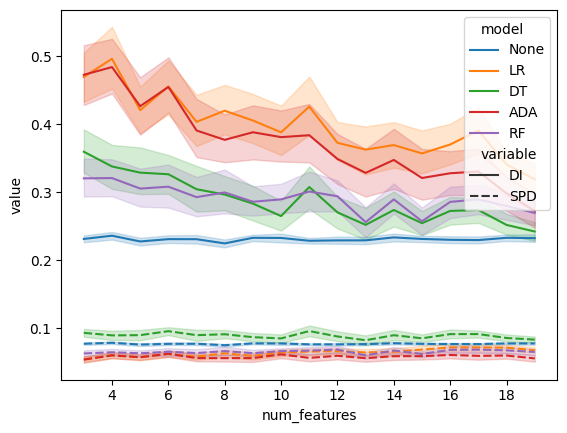

In [ ]:
id_vars = ["num_features", "model", "dataset", "accuracy", "f1"]
_ = data[(data["dataset"] == "bank-age")]

sns.lineplot(
    data=_.melt(id_vars=id_vars),
    x="num_features",
    y="value",
    hue="model",
    style="variable",
)

## Correlation
In this section we employ correlation to test if there is a relationship between the data & model metrics. From the section above, we note that the distribution of the populations are not normal.

We use the Spearman's correlation since it does not assume normality & is robust to outliers.

We will create individual tables for each subset (train & test).

$$
DI = \frac{P(y=1 | D=unprivileged)}{P(y=1 | D=privileged)}
$$
$$
SPD = P(y=1 | D=unprivileged) - P(y=1 | D=privileged)
$$

### Test subset | DI

In [23]:
# test subset | DI
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
    models]

corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d) &
        (data["subset"] == "test")
    ]
    for metric in ["DI", "SPD"]:
        _pivots = []
        for n in _["num_features"].unique().tolist():
            _pivots.append(pd.pivot(
                data=_[_["num_features"] == n],
                columns="model",
                values=metric,
            ))
        pivoted = pd.concat(_pivots)
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr


compas-sex german-age adult-sex compas-race  bank-age german-sex  \
metric model                                                                    
DI     LR     -0.225345  -0.050071  0.240653   -0.297926  0.156561   0.030792   
       DT     -0.034421  -0.060581  0.048913   -0.013552  0.132747  -0.016263   
       ADA    -0.127871  -0.062592  0.225354   -0.068616  0.151671  -0.071031   
       RF     -0.103898   0.002506  0.228388   -0.094713   0.16645   0.130098   
SPD    LR     -0.211988  -0.044858  0.265537   -0.284676  0.177044   0.033013   
       DT     -0.034139  -0.055757  0.194183   -0.023472  0.160414  -0.010924   
       ADA    -0.128575  -0.060677  0.172968   -0.042923  0.182448  -0.068694   
       RF     -0.100164   0.011444  0.222789   -0.092025  0.191342   0.137343   

             meps-race adult-race  
metric model                       
DI     LR     0.195001   0.199128  
       DT     0.079184   0.140646  
       ADA    0.190545   0.174875  
       RF     0.199325   0.254928  
SPD    LR     0.194962   0.204873  
       DT     0.089947   0.194424  
       ADA    0.196549   0.181991  
       RF     0.157954   0.265409

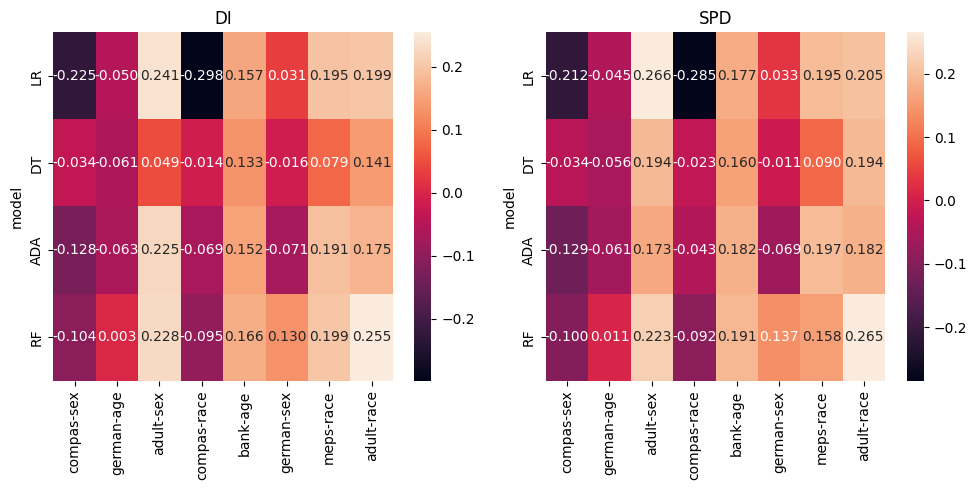

In [24]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5)
)

ax = axs[0]
ax.set_title("DI")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["DI", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

ax = axs[1]
ax.set_title("SPD")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["SPD", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

fig.tight_layout()

In [25]:
corr_pvalues.applymap(
    lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t])
)

compas-sex german-age adult-sex compas-race bank-age german-sex  \
metric model                                                                   
DI     LR           ***                  ***         ***      ***              
       DT                        *                            ***              
       ADA           **          *       ***                  ***         **   
       RF             *                  ***           *      ***        ***   
SPD    LR           ***                  ***         ***      ***              
       DT                        *       ***                  ***              
       ADA           **          *       ***                  ***         **   
       RF             *                  ***           *      ***        ***   

             meps-race adult-race  
metric model                       
DI     LR          ***        ***  
       DT          ***        ***  
       ADA         ***        ***  
       RF          ***        ***  
SPD    LR          ***        ***  
       DT          ***        ***  
       ADA         ***        ***  
       RF          ***        ***

### Train subset | DI

In [26]:
# train subset | DI
indices = [[
    "DI",
    "SPD",
],
    models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
_frames = []

# grab the train data fairness metrics
_ = data[
    (data["model"] == "None") &
    (data["subset"] == "train")
]
_frames.append(_)

# grab the model metrics
_ = data[(data["model"] != "None")]
_frames.append(_)

frames = pd.concat(_frames)

for d in datasets:
    _ = frames[
        (frames["dataset"] == d)
    ]
    for metric in ["DI", "SPD"]:
        _pivots = []
        for n in _["num_features"].unique().tolist():
            _pivots.append(pd.pivot(
                data=_[_["num_features"] == n],
                columns="model",
                values=metric,
            ))
        pivoted = pd.concat(_pivots)
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

compas-sex german-age adult-sex compas-race  bank-age german-sex  \
metric model                                                                    
DI     LR      0.223336   0.052725 -0.240963    0.295859 -0.153758  -0.021581   
       DT      0.040935    0.05838 -0.049295    0.011591 -0.132081   0.018312   
       ADA      0.12414   0.064279 -0.226526    0.066226 -0.148982   0.072153   
       RF      0.098857   0.002578 -0.228266    0.088987 -0.165327  -0.133686   
SPD    LR      0.211098   0.048823 -0.265361    0.285643 -0.173914  -0.023801   
       DT      0.040948   0.054094 -0.195322    0.020885 -0.158716   0.012901   
       ADA     0.128078   0.062317  -0.17264    0.042289 -0.179555   0.070518   
       RF      0.099066  -0.007212 -0.222428     0.09027 -0.189575  -0.139032   

             meps-race adult-race  
metric model                       
DI     LR    -0.194446  -0.200347  
       DT    -0.079732  -0.138497  
       ADA   -0.189706  -0.175491  
       RF    -0.199683  -0.257292  
SPD    LR    -0.194669  -0.204617  
       DT    -0.089753  -0.193741  
       ADA   -0.195979  -0.181749  
       RF    -0.157593  -0.264919

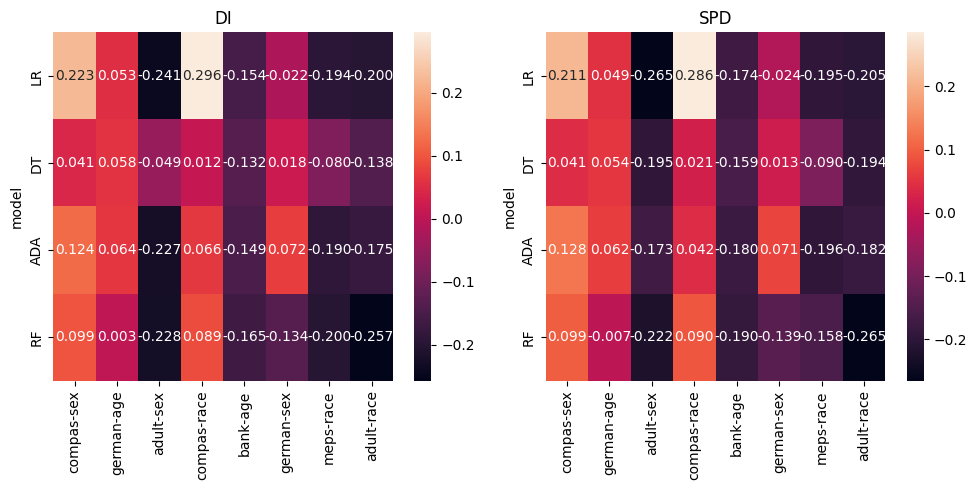

In [27]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5)
)

ax = axs[0]
ax.set_title("DI")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["DI", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

ax = axs[1]
ax.set_title("SPD")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["SPD", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

fig.tight_layout()

In [14]:
corr_pvalues.applymap(
    lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t])
)

,compas-sex,german-age,adult-sex,compas-race,bank-age,german-sex,meps-race,adult-race
model,,,,,,,,
adaboostclassifier,**,*,***,,***,**,***,***
decisiontreeclassifier,,*,,,***,,***,***
logisticregression,***,,***,***,***,,***,***
randomforestclassifier,*,,***,*,***,***,***,***


## Linear Regression
In this section we employ linear regression to analyse relationship between the data & model fairness metrics.

We collect the following metrics:

1. min, max & avg for $v_{test/train, d}$
2. min, max & avg for $v_{m\prime, d}$
3. coefficient(slope) of the linear regression model

In [15]:
# test subset | DI
d = {
    "dataset": [],
    "model": [],
    "x_min": [],
    "x_max": [],
    "x_mean": [],
    "y_min": [],
    "y_max": [],
    "y_mean": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
}

for dataset in datasets:
    x = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "test") &
        (data["model"] == "None")
    ]["disparate_impact"]

    for model in models:
        y = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]["disparate_impact"]
        mod = sm.OLS(
            endog=y.values.reshape(-1, 1),
            exog=x.values.reshape(-1, 1),
        )
        res = mod.fit()

        d["dataset"].append(dataset)
        d["model"].append(model)
        d["x_min"].append(x.min())
        d["x_max"].append(x.max())
        d["x_mean"].append(x.mean())
        d["y_min"].append(y.min())
        d["y_max"].append(y.max())
        d["y_mean"].append(y.mean())
        d["slope"].append(res.params[0])
        d["r2"].append(res.rsquared)
        d["f_pvalue"].append(res.f_pvalue)

reg = pd.DataFrame(data=d)
reg

,dataset,model,x_min,x_max,x_mean,y_min,y_max,y_mean,slope,r2,f_pvalue
0,compas-sex,logisticregression,0.021234,0.112234,0.072479,0.089222,0.165939,0.123278,1.632452,0.945028,6.259648e-222
1,compas-sex,decisiontreeclassifier,0.021234,0.112234,0.072479,0.026544,0.141342,0.080121,1.063470,0.904307,6.544312e-180
2,compas-sex,adaboostclassifier,0.021234,0.112234,0.072479,0.052841,0.197973,0.114332,1.511618,0.899329,4.572898e-176
3,compas-sex,randomforestclassifier,0.021234,0.112234,0.072479,0.040147,0.151043,0.097160,1.287019,0.929976,1.384667e-203
4,german-age,logisticregression,0.001191,0.185386,0.076369,0.000324,0.216894,0.089395,0.971829,0.707103,6.141079e-242
5,german-age,decisiontreeclassifier,0.001191,0.185386,0.076369,0.000000,0.182772,0.058753,0.635420,0.580093,1.413001e-171
6,german-age,adaboostclassifier,0.001191,0.185386,0.076369,0.000324,0.201695,0.085657,0.926204,0.681958,7.489328e-226
7,german-age,randomforestclassifier,0.001191,0.185386,0.076369,0.000268,0.152623,0.056009,0.615981,0.656341,1.012539e-210
8,adult-sex,logisticregression,0.216409,0.253063,0.234680,0.239396,0.287585,0.262312,1.117284,0.998917,0.000000e+00
9,adult-sex,decisiontreeclassifier,0.216409,0.253063,0.234680,0.202013,0.271264,0.232988,0.992294,0.996360,0.000000e+00


<AxesSubplot: xlabel='r2', ylabel='Count'>

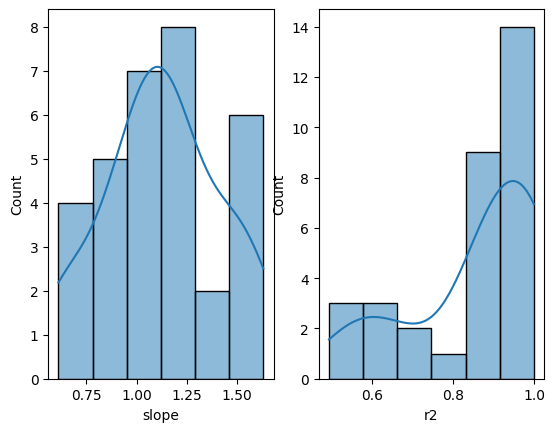

In [16]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)

ax= axs[0]
sns.histplot(
    data=reg,
    x="slope",
    ax=ax,
    kde=True,
)

ax= axs[1]
sns.histplot(
    data=reg,
    x="r2",
    ax=ax,
    kde=True,
)

In [17]:
# train subset | DI
d = {
    "dataset": [],
    "model": [],
    "x_min": [],
    "x_max": [],
    "x_mean": [],
    "y_min": [],
    "y_max": [],
    "y_mean": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
}

for dataset in datasets:
    x = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]["disparate_impact"]

    for model in models:
        y = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]["disparate_impact"]
        mod = sm.OLS(
            endog=y.values.reshape(-1, 1),
            exog=x.values.reshape(-1, 1),
        )
        res = mod.fit()

        d["dataset"].append(dataset)
        d["model"].append(model)
        d["x_min"].append(x.min())
        d["x_max"].append(x.max())
        d["x_mean"].append(x.mean())
        d["y_min"].append(y.min())
        d["y_max"].append(y.max())
        d["y_mean"].append(y.mean())
        d["slope"].append(res.params[0])
        d["r2"].append(res.rsquared)
        d["f_pvalue"].append(res.f_pvalue)

reg = pd.DataFrame(data=d)
reg

,dataset,model,x_min,x_max,x_mean,y_min,y_max,y_mean,slope,r2,f_pvalue
0,compas-sex,logisticregression,0.057990,0.087769,0.072630,0.089222,0.165939,0.123278,1.693078,0.988308,0.000000e+00
1,compas-sex,decisiontreeclassifier,0.057990,0.087769,0.072630,0.026544,0.141342,0.080121,1.099513,0.939810,4.679867e-215
2,compas-sex,adaboostclassifier,0.057990,0.087769,0.072630,0.052841,0.197973,0.114332,1.571033,0.944451,3.878644e-221
3,compas-sex,randomforestclassifier,0.057990,0.087769,0.072630,0.040147,0.151043,0.097160,1.334052,0.971454,1.343826e-271
4,german-age,logisticregression,0.034064,0.114703,0.075482,0.000324,0.216894,0.089395,1.162944,0.848044,0.000000e+00
5,german-age,decisiontreeclassifier,0.034064,0.114703,0.075482,0.000000,0.182772,0.058753,0.765121,0.704422,3.695734e-240
6,german-age,adaboostclassifier,0.034064,0.114703,0.075482,0.000324,0.201695,0.085657,1.116020,0.829251,0.000000e+00
7,german-age,randomforestclassifier,0.034064,0.114703,0.075482,0.000268,0.152623,0.056009,0.726029,0.763662,7.708091e-284
8,adult-sex,logisticregression,0.228827,0.241145,0.235107,0.239396,0.287585,0.262312,1.115575,0.998961,0.000000e+00
9,adult-sex,decisiontreeclassifier,0.228827,0.241145,0.235107,0.202013,0.271264,0.232988,0.990891,0.996638,0.000000e+00


<AxesSubplot: xlabel='r2', ylabel='Count'>

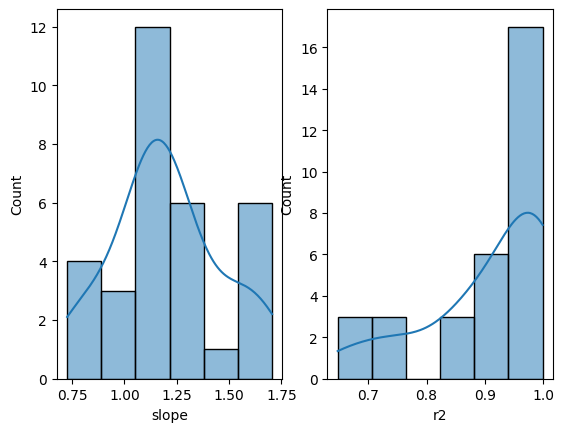

In [18]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)

ax= axs[0]
sns.histplot(
    data=reg,
    x="slope",
    ax=ax,
    kde=True,
)

ax= axs[1]
sns.histplot(
    data=reg,
    x="r2",
    ax=ax,
    kde=True,
)

# Identifying $num\_features$ that captures variety of fairness issues

In [35]:
from scipy.stats import spearmanr

d = {
    "metric": [],
    "num_features": [],
    "corr": [],
    "model": [],
    "dataset": [],
}

for dataset in datasets:
    _ = data[data["dataset"] == dataset]
    for metric in ["DI", "SPD"]:
        for n in _["num_features"].unique().tolist():
            pivot = pd.pivot(
                data=_[_["num_features"] == n],
                columns="model",
                values=metric,
            )
            for model in models:
                c, p = spearmanr(pivot[model], pivot["None"])
                d["metric"].append(metric)
                d["num_features"].append(n)
                d["corr"].append(c)
                d["model"].append(model)
                d["dataset"].append(dataset)

corr = pd.DataFrame(data=d)
corr

,metric,num_features,corr,model,dataset
0,DI,3,-0.153613,LR,german-age
1,DI,3,0.140456,DT,german-age
2,DI,3,-0.118463,ADA,german-age
3,DI,3,-0.205095,RF,german-age
4,DI,4,0.037983,LR,german-age
...,...,...,...,...,...
995,SPD,10,-0.266651,RF,adult-sex
996,SPD,11,-0.398319,LR,adult-sex
997,SPD,11,-0.129124,DT,adult-sex
998,SPD,11,-0.464490,ADA,adult-sex


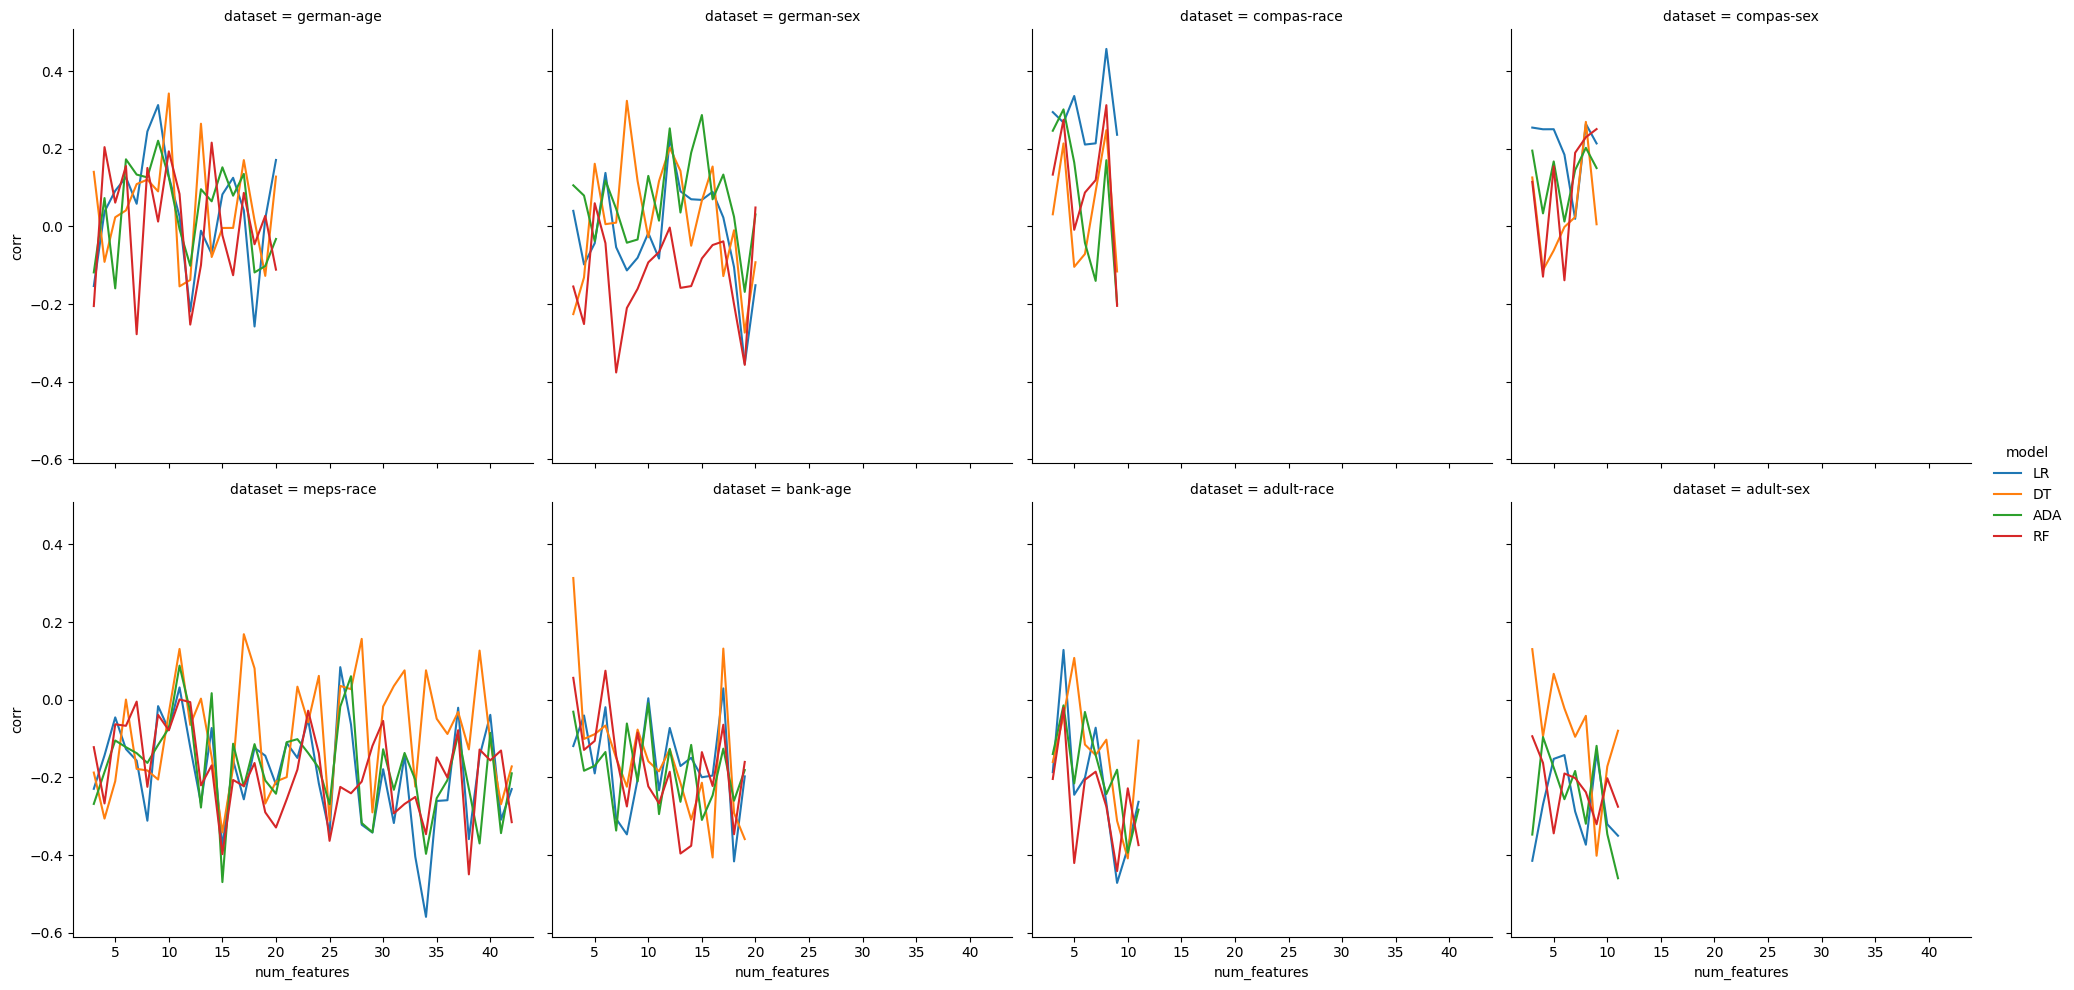

In [39]:
sns.relplot(
    kind="line",
    data=corr[corr["metric"] == "DI"],
    hue="model",
    x="num_features",
    y="corr",
    errorbar=None,
    col="dataset",
    col_wrap=4,
)

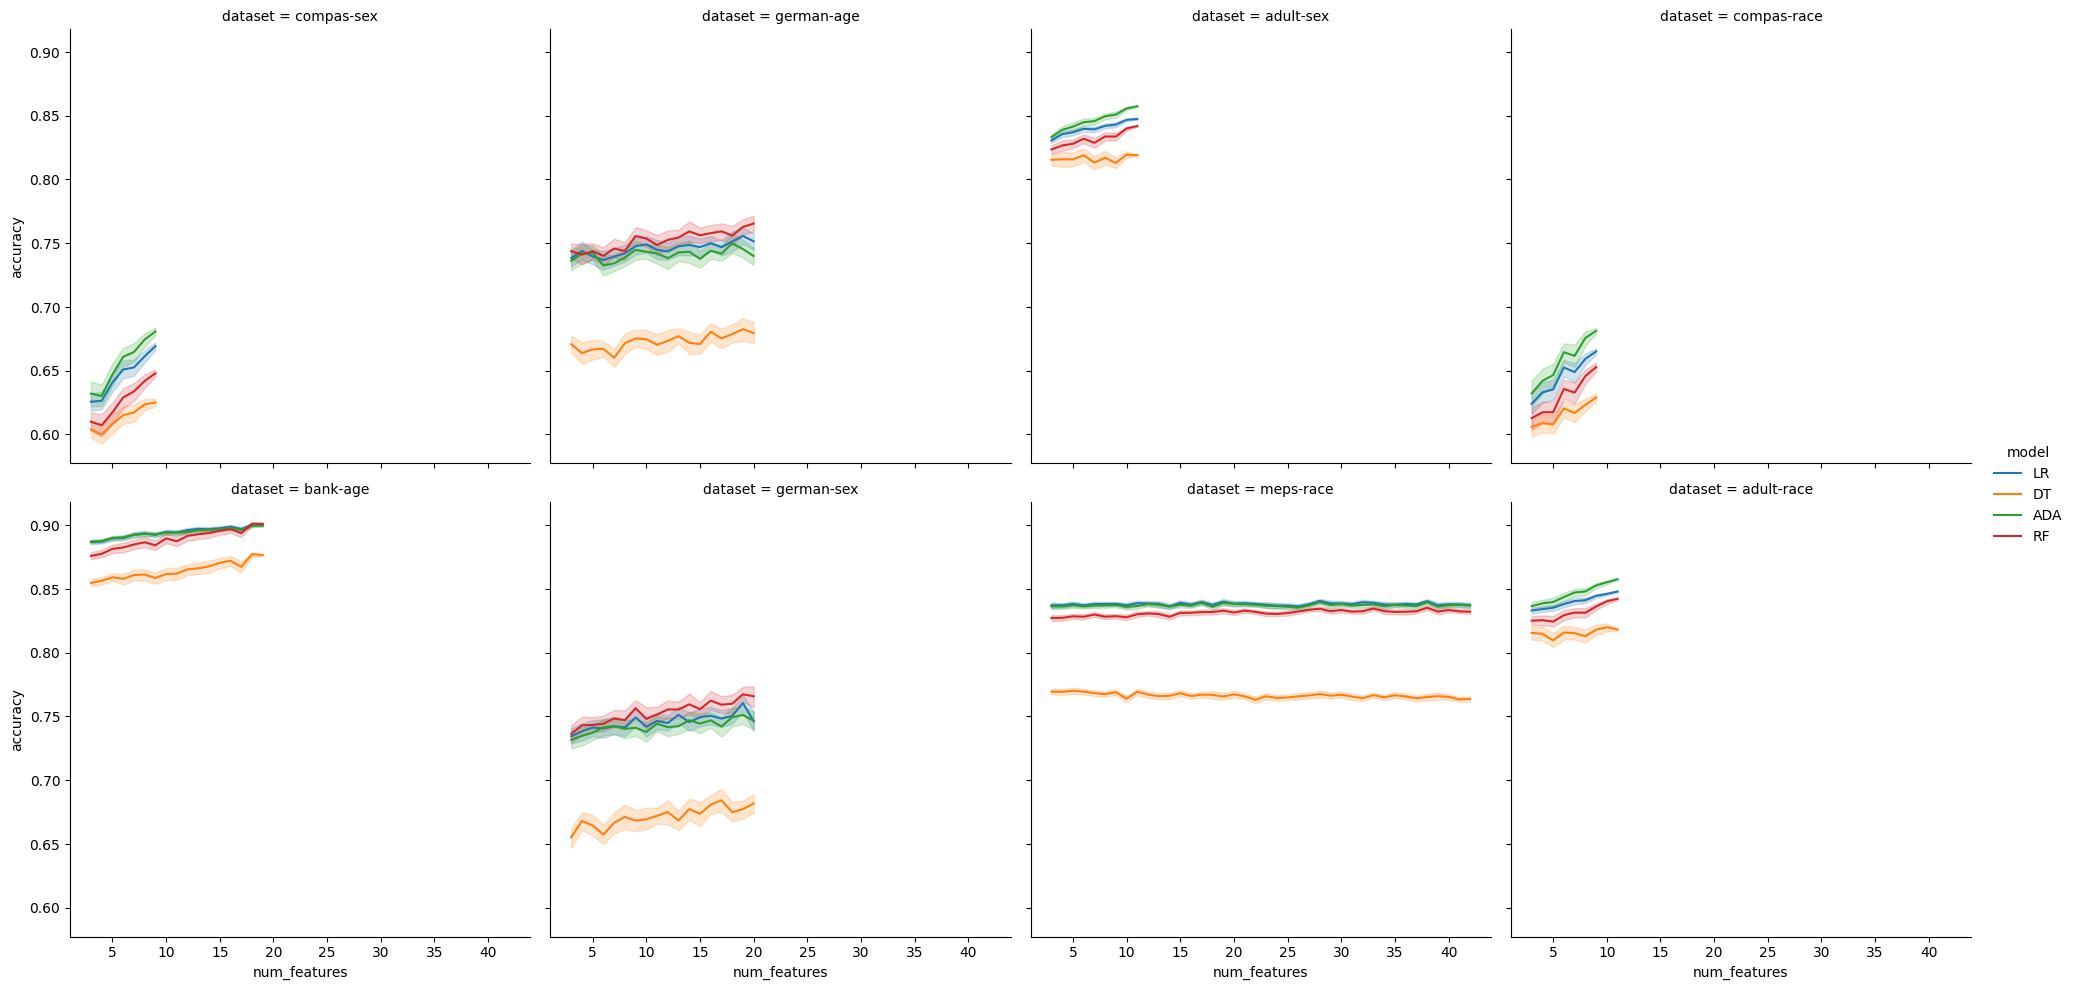

In [29]:
_ = data[
    (data["model"] != "None")
]
sns.relplot(
    kind="line",
    data=_,
    x="num_features",
    y="accuracy",
    hue="model",
    col="dataset",
    col_wrap=4,
)

In [32]:
from scipy.stats import ttest_ind

d = {
    "metric": [],
    "model": [],
    "dataset": [],
    "start": [],
    "stop": [],
    "pvalue": [],
}

for dataset in datasets:
    stops = data.loc[(data["dataset"] == dataset), "num_features"].unique().tolist()
    for model in models:
        for metric in ["accuracy", "f1"]:
            _ = data[
                (data["dataset"] == dataset) &
                (data["model"] == model)
            ]
            for stop in stops:
                _start = _.loc[_["num_features"] == max(stops), metric]
                _stop = _.loc[_["num_features"] == stop, metric]
                d["metric"].append(metric)
                d["model"].append(model)
                d["dataset"].append(dataset)
                d["start"].append(max(stops))
                d["stop"].append(stop)
                d["pvalue"].append(ttest_ind(_start, _stop).pvalue)

cutoff = pd.DataFrame(data=d)
cutoff.head()

,metric,model,dataset,start,stop,pvalue
0,accuracy,LR,german-age,20,3,0.007889
1,accuracy,LR,german-age,20,4,0.131988
2,accuracy,LR,german-age,20,5,0.010138
3,accuracy,LR,german-age,20,6,0.004261
4,accuracy,LR,german-age,20,7,0.014560


In [33]:
d = {
    "dataset": [],
    "num_features": [],
    "count": [],
}

for dataset in datasets:
    _ = cutoff[cutoff["dataset"] == dataset]
    for n in _["stop"].unique():
        count = _.loc[(_["stop"] == n) & (_["pvalue"] < 0.05)].shape[0]
        d["dataset"].append(dataset)
        d["num_features"].append(n)
        d["count"].append(count)

cutoff_count = pd.DataFrame(data=d)
cutoff_count

,dataset,num_features,count
0,german-age,3,4
1,german-age,4,3
2,german-age,5,5
3,german-age,6,5
4,german-age,7,5
...,...,...,...
120,adult-sex,7,8
121,adult-sex,8,7
122,adult-sex,9,8
123,adult-sex,10,3


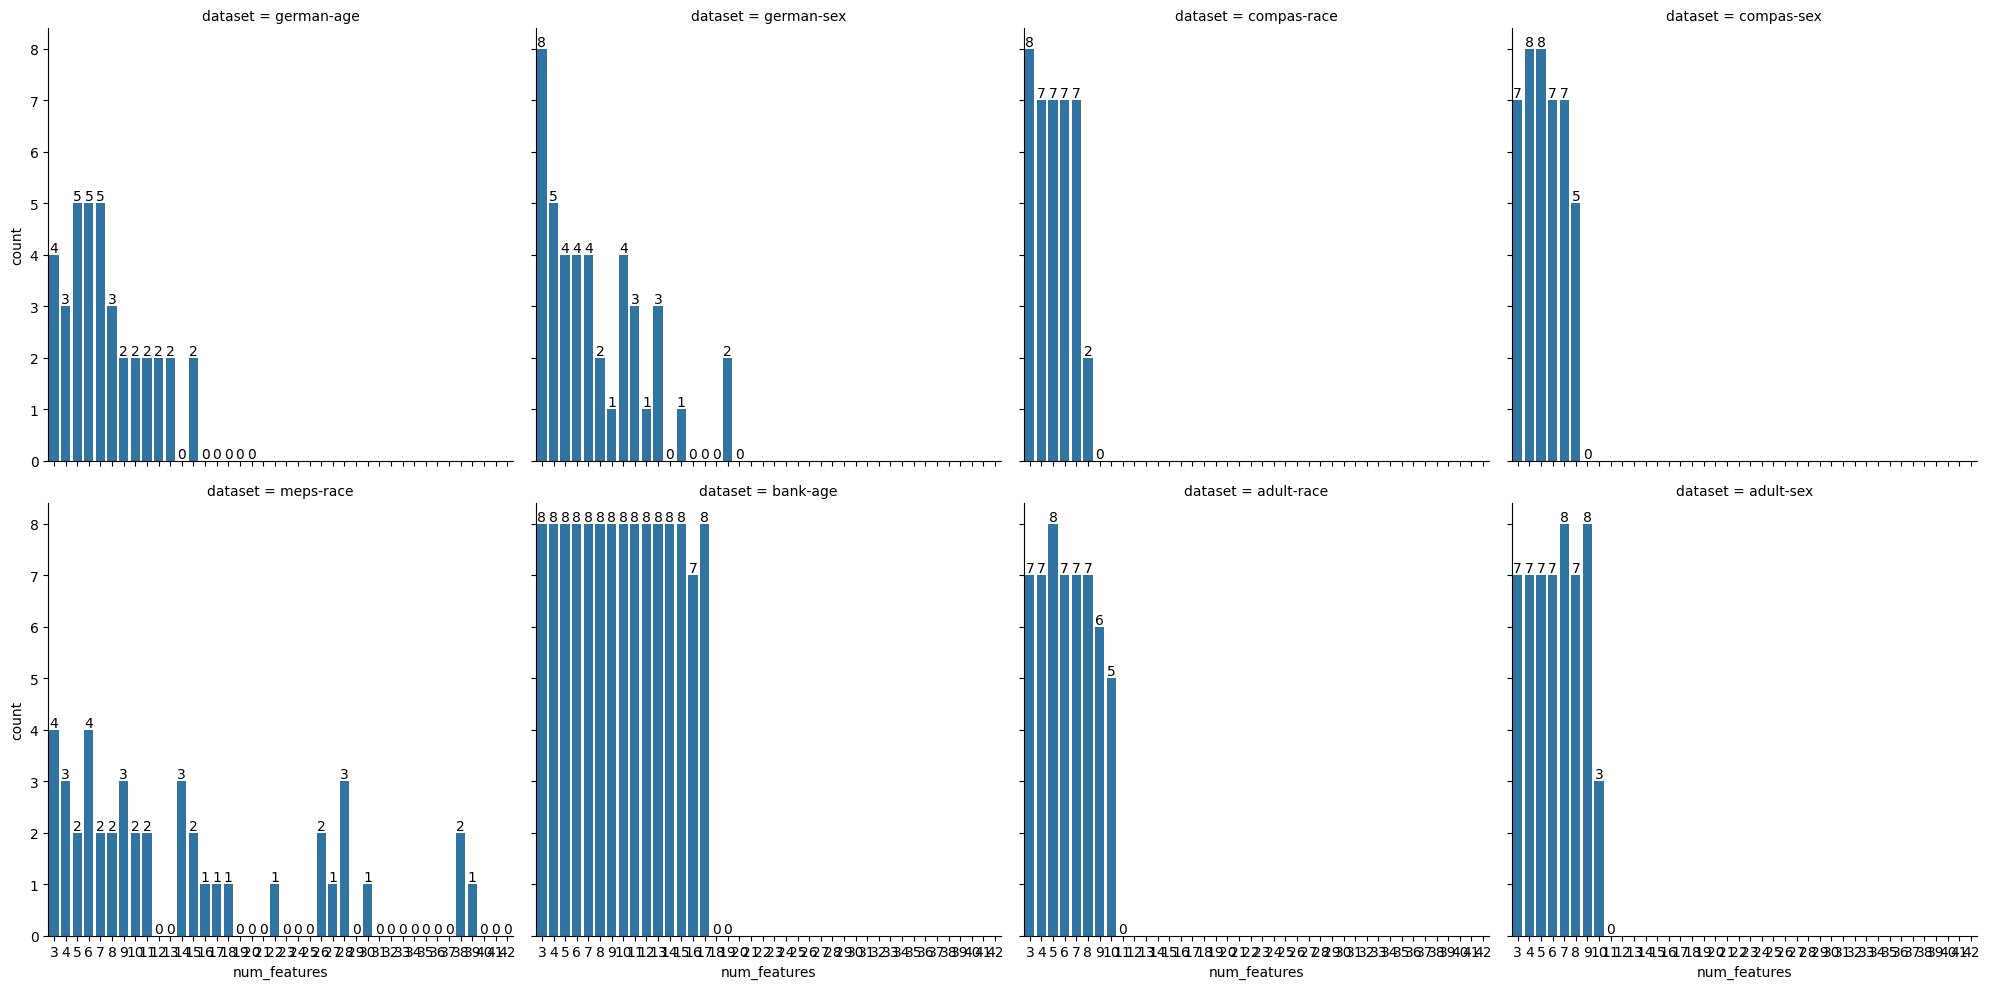

In [34]:
g = sns.catplot(
    kind="bar",
    data=cutoff_count,
    col="dataset",
    col_wrap=4,
    x="num_features",
    y="count",
    color="tab:blue",
)

for ax in g.axes:
    ax.bar_label(ax.containers[0], label_type="edge")

In [ ]:
)